# Klasifikace a logistická regrese

  * Import používaných knihoven.
  * Logistická regrese je v `sklearn.linear_model` jako `LogisticRegression`.
  * Používá se pak klasicky dle obvyklého API modelů ve `scikit-learn`.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
from sklearn import neighbors 
from sklearn.linear_model import LogisticRegression

## Umělá data

  * Vygenerujeme si umělá data s dvěma příznaky $X_0$ a $X_1$ a binární vysvětlovanou promennou.
  * Je to směs dvou dvourozměrných Gaussiánů.


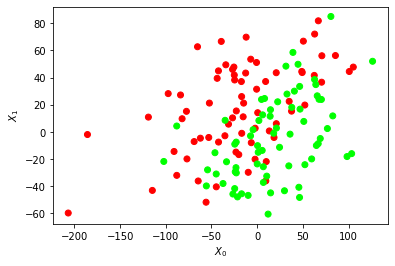

In [2]:
mean1 = [-20, 20]
cov1 = [[3000, 850], [850, 1000]]
mean2 = [10, -10]
cov2 = [[3000, 850], [850, 1000]]
n1 = 70
n2 = 70
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])

X1 = np.random.multivariate_normal(mean1, cov1, n1)
y1 = np.zeros(n1,dtype="int")
X2 = np.random.multivariate_normal(mean2, cov2, n2)
y2 = np.ones(n2,dtype="int")

X = np.concatenate((X1,X2), axis=0)
y = np.concatenate((y1,y2), axis=0)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
plt.xlabel('$X_0$')
plt.ylabel('$X_1$')
plt.show()

## Rozhodovací hranice (boundary decision)

### KNN

  * Použijeme pro srovnání KNN, které známe, a ukážeme si, jak vypadá hranice, kde se mění rozhodnutí.

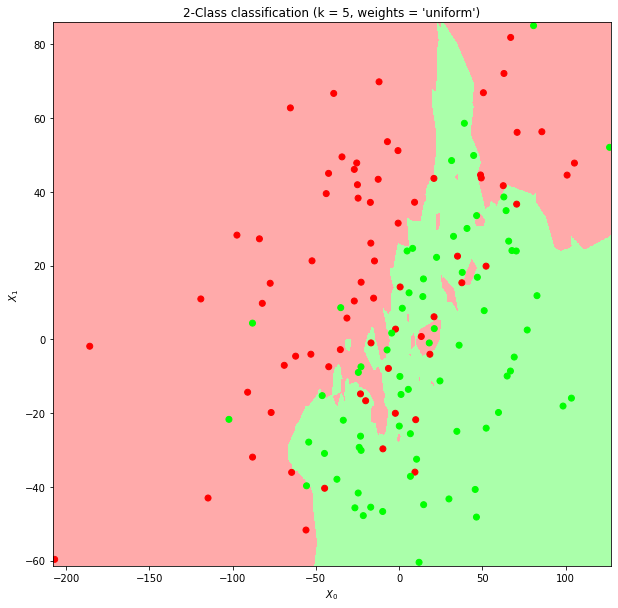

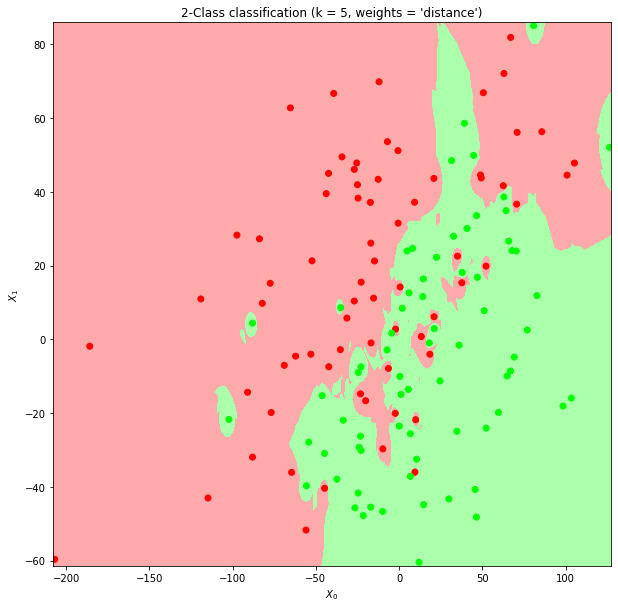

In [3]:
h = 0.2  # step size in the mesh
n_neighbors = 5

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clfKNN = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clfKNN.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clfKNN.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(10,10))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel('$X_0$')
    plt.ylabel('$X_1$')
    plt.title("2-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))
plt.show()

### Logistická regrese 

  * U logistické regrese je hranice dána příslušnou nadrovinou.
  * Mohlo by se stát, že bychom vytvořili kruhovou rozhodovací hranici?

[[ 0.02750747 -0.04354344]] [0.23402772]


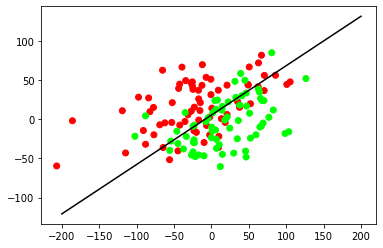

In [4]:
clfLOG = LogisticRegression(solver='newton-cg')
clfLOG.fit(X,y)
print(clfLOG.coef_, clfLOG.intercept_)

def fun(x, intercept, coef1, coef2):
    y = (-1/coef2)*(intercept + coef1*x)
    return y
# uděláme vektorovou funkci aby šlapala na ndarray
vfun = np.vectorize(fun)
xgrid = np.linspace(-200, 200, 200)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
plt.plot(xgrid, vfun(xgrid, clfLOG.intercept_, clfLOG.coef_[0,0], clfLOG.coef_[0,1]), 'k-')
plt.show()

### Uložení výsledného modelu

* V případě přenesení naučeného modelu do produkce či prostě při potřebě uložení výsledků práce je dobré moci si uložit výsledný model do souboru, ze kterého jej lze později našíst.
* Lze využít balíček [pickle](https://docs.python.org/3/library/pickle.html#module-pickle).
* Pro složitější struktury lze použít [joblib](https://pypi.org/project/joblib/).

In [5]:
import os, pickle # package for serializing objects in Python
filename = 'clfLOG.sav'
pickle.dump(clfLOG, open(filename, 'wb')) # saving the model

clfLOG_loaded = pickle.load(open(filename, 'rb'))
print('Coeficients of original model:', clfLOG.coef_, clfLOG.intercept_)
print('Coefficients of loaded model:', clfLOG_loaded.coef_, clfLOG_loaded.intercept_)
print('Filesize: ', os.stat(filename).st_size, 'bytes')

Coeficients of original model: [[ 0.02750747 -0.04354344]] [0.23402772]
Coefficients of loaded model: [[ 0.02750747 -0.04354344]] [0.23402772]
Filesize:  848 bytes


In [6]:
filename = 'clfKNN.sav'
pickle.dump(clfKNN, open(filename, 'wb')) # saving the model

clfNN_loaded = pickle.load(open(filename, 'rb'))
print('Filesize: ', os.stat(filename).st_size, 'bytes')

Filesize:  6243 bytes


## Parciální derivace a gradient

**Úkol**: Najděte gradient funkce $\ell(\mathbf{w})$ (viz přednášku):
$$
    \ell(\mathbf{w}) = \sum_{i = 1}^N \left(Y_i \ln \left( \frac{e^{\vec{w}^T \vec{x}}}{1 + e^{\vec{w}^T \vec{x}}} \right) + (1 - Y_i) \ln \left( \frac{1}{1 + e^{\vec{w}^T \vec{x}}} \right)\right).
$$
  * Pokuste se přepsat výsledek do maticového tvaru.
  * Projděte si [ukázku](https://courses.fit.cvut.cz/MI-MPI/media/tutorials/mpi-ukazka-1-parcialni-derivace-v1.pdf) z předmětu MI-MPI a pokuste se pochopit geometrickou interpretaci  parciální derivace a gradientu (příp. i Hessovy matice).


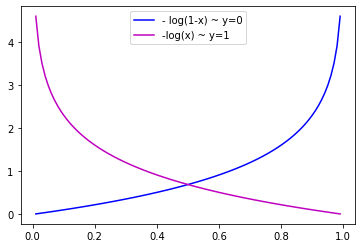

In [7]:
x = np.linspace(0.01, 0.99, 100)
plt.plot(x, -np.log(1-x), '-b', label="- log(1-x) ~ y=0")
plt.plot(x, -np.log(x), '-m', label="-log(x) ~ y=1")
plt.legend()

In [8]:
def g(x):
    return 1 / (1 + np.exp(-x))

def hypothesis(X, w):
    return g(X*w)

def cost(X, y, w):
    h = hypothesis(X, w)
    return (-y.T * np.log(h) - (1-y).T * np.log(1-h)).sum()

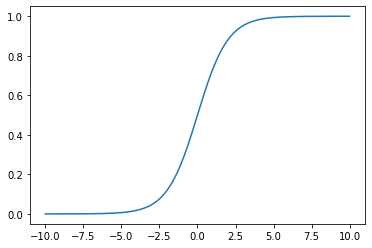

In [9]:
x = np.linspace(-10, +10, 1000)
plt.plot(x, g(x))

In [15]:
def gradient(X, y, eta, steps, norm):
    norms=[]
    w=np.zeros(shape=(X.shape[1],1))
    for i in range(steps):
        grad = X.T * (hypothesis(X, w) - y)
        if i > 50:
            norms.append(np.linalg.norm(grad))
        if (np.linalg.norm(grad) < norm):
            print("Gradient converged in", i)
            break
        w = w + eta * (-grad)
    return w, norms

[[ 0.02727706]
 [-0.04181378]
 [ 0.00188165]]


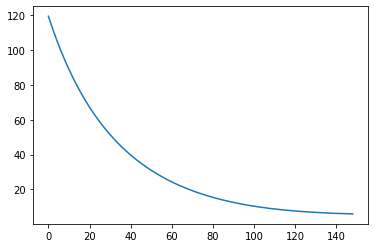

In [16]:
Xi = np.matrix(np.append(X, np.ones(shape=(X.shape[0],1)), axis=1))
w, norms = gradient(Xi, np.matrix(y).T, 0.000002, 200, 0.000001)
print(w)
plt.plot(norms)
plt.show()

In [ ]:
x = np.linspace(-200, +200, 1000)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
plt.plot(xgrid, vfun(xgrid, clfLOG.intercept_, clfLOG.coef_[0,0], clfLOG.coef_[0,1]), 'k-')
plt.show()